# Star-Galaxy Classification using Inception-Network based Convolutional Neural Network (CNN) Model 

#### Problem Statement: 
##### Given an image classify it as a star or galaxy uisng a Computer Vision algorithm.

#### Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
# from tqdm.notebook 
import tqdm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


#### 1. Load and extract the dataset

In [2]:
X = np.load("/home/srinadb/SG/SGP/Dataset/Experiment1/X_exp1.npy")
dnnx = np.load("/home/srinadb/SG/SGP/Dataset/Experiment1/dnnx_exp1.npy")
objlist = np.load("/home/srinadb/SG/SGP/Dataset/Experiment1/objlist_exp1.npy")
y = np.load("/home/srinadb/SG/SGP/Dataset/Experiment1/y_exp1.npy", allow_pickle=True)

idx_drop = np.where(y=="QSO")[0]
X = np.delete(X,idx_drop,axis=0)
dnnx = np.delete(dnnx,idx_drop,axis=0)
y = np.delete(y,idx_drop,axis=0)
objlist = np.delete(objlist,idx_drop,axis=0)
y, label_strings = pd.factorize(y,sort=True)
# y = to_categorical(y)
print('\n')
print(label_strings)




['GALAXY' 'STAR']


In [3]:
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.125,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1428, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

del(dnnx_train, dnnx_val, dnnx_test)

X_train = X_train.transpose((0, 3, 1, 2))
X_val = X_val.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))

print('\n')
print('The shape of the Train data is:', X_train.shape)
print('The shape of the Validation data is:', X_val.shape)
print('The shape of the Test data is:', X_test.shape)




The shape of the Train data is: (120007, 5, 32, 32)
The shape of the Validation data is: (19992, 5, 32, 32)
The shape of the Test data is: (20000, 5, 32, 32)


In [4]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)
    


##### Create dataset and dataloader for pytorch training

In [5]:
class SGData(Dataset):
    def __init__(self, x, y, transform=None):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs, targets = self.x[i], self.y[i]
        
        if self.transform:
            inputs = self.transform(inputs)

        return inputs, targets

# Define your data augmentation transformations
image_transform = transforms.Compose([    
    transforms.RandomRotation(180),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create DataLoader for training and validation data
train_dataset = SGData(X_train, y_train, transform=image_transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8)
val_dataset = SGData(X_val, y_val, transform=image_transform)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)
test_dataset = SGData(X_test, y_test, transform=None)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)


#### 2. Define the CNN MOdel

In [6]:
class InceptionModel(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(InceptionModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=5, padding=2)

        self.conv2_1 = nn.Conv2d(64, 48, kernel_size=1, padding=0)
        self.conv2_2 = nn.Conv2d(64, 48, kernel_size=1, padding=0)
        self.conv2_3 = nn.Conv2d(64, 48, kernel_size=1, padding=0)
        self.conv2_4 = nn.Conv2d(48, 64, kernel_size=1, padding=0)
        self.conv2_5 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.conv2_6 = nn.Conv2d(48, 64, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=1, stride=1)

        self.conv3_1 = nn.Conv2d(240, 64, kernel_size=1, padding=0)
        self.conv3_2 = nn.Conv2d(240, 64, kernel_size=1, padding=0)
        self.conv3_3 = nn.Conv2d(240, 64, kernel_size=1, padding=0)
        self.conv3_4 = nn.Conv2d(64, 92, kernel_size=1, padding=0)
        self.conv3_5 = nn.Conv2d(64, 92, kernel_size=3, padding=1)
        self.conv3_6 = nn.Conv2d(64, 92, kernel_size=5, padding=2)
        self.pool2 = nn.AvgPool2d(kernel_size=1, stride=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(340, 92, kernel_size=1, padding=0)
        self.conv4_2 = nn.Conv2d(340, 92, kernel_size=1, padding=0)
        self.conv4_3 = nn.Conv2d(340, 92, kernel_size=1, padding=0)
        self.conv4_4 = nn.Conv2d(92, 128, kernel_size=1, padding=0)
        self.conv4_5 = nn.Conv2d(92, 128, kernel_size=3, padding=1)
        self.conv4_6 = nn.Conv2d(92, 128, kernel_size=5, padding=2)
        self.pool4 = nn.AvgPool2d(kernel_size=1, stride=1)
        
        self.conv5_1 = nn.Conv2d(476, 92, kernel_size=1, padding=0)
        self.conv5_2 = nn.Conv2d(476, 92, kernel_size=1, padding=0)
        self.conv5_3 = nn.Conv2d(476, 92, kernel_size=1, padding=0)
        self.conv5_4 = nn.Conv2d(92, 128, kernel_size=1, padding=0)
        self.conv5_5 = nn.Conv2d(92, 128, kernel_size=3, padding=1)
        self.conv5_6 = nn.Conv2d(92, 128, kernel_size=5, padding=2)
        self.pool5 = nn.AvgPool2d(kernel_size=1, stride=1)
        self.pool6 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv6_1 = nn.Conv2d(476, 92, kernel_size=1, padding=0)
        self.conv6_2 = nn.Conv2d(476, 92, kernel_size=1, padding=0)
        self.conv6_3 = nn.Conv2d(476, 128, kernel_size=1, padding=0)
        self.conv6_4 = nn.Conv2d(92, 128, kernel_size=3, padding=1)
        self.pool7 = nn.AvgPool2d(kernel_size=1, stride=1)

        self.fc1 = nn.Linear(22272, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, n_classes)

    def forward(self, x):
        # Input Image shape; x (32, 32, 5)
        x = F.relu(self.conv1(x)) # x: 32, 32, 64

        c1 = F.relu(self.conv2_1(x)) # x: 32, 32, 48
        c2 = F.relu(self.conv2_2(x)) # x: 32, 32, 48
        c3 = F.relu(self.conv2_3(x)) # x: 32, 32, 48
        c4 = F.relu(self.conv2_4(c1)) # x: 32, 32, 64
        c5 = F.relu(self.conv2_5(c1))  # x: 32, 32, 64
        c6 = F.relu(self.conv2_6(c2))  # x: 32, 32, 64
        p1 = self.pool1(c3)  # x: 32, 32, 48
        x = torch.cat((c4, c5, c6, p1), dim=1)  # x: 32, 32, 240
        
        c7 = F.relu(self.conv3_1(x)) # x: 32, 32, 64
        c8 = F.relu(self.conv3_2(x)) # x: 32, 32, 64
        c9 = F.relu(self.conv3_3(x)) # x: 32, 32, 64
        c10 = F.relu(self.conv3_4(c7)) # x: 32, 32, 92
        c11 = F.relu(self.conv3_5(c7)) # x: 32, 32, 92
        c12 = F.relu(self.conv3_6(c8)) # x: 32, 32, 92
        p2 = self.pool2(c9) # x: 32, 32, 64
        x = torch.cat((c10, c11, c12, p2), dim=1) # x: 32, 32, 340
        x = self.pool3(x) # x: 16, 16, 340
        
        c13 = F.relu(self.conv4_1(x)) # x: 16, 16, 92
        c14 = F.relu(self.conv4_2(x)) # x: 16, 16, 92
        c15 = F.relu(self.conv4_3(x)) # x: 16, 16, 92
        c16 = F.relu(self.conv4_4(c13)) # x: 16, 16, 128
        c17 = F.relu(self.conv4_5(c13)) # x: 16, 16, 128
        c18 = F.relu(self.conv4_6(c14)) # x: 16, 16, 128
        p3 = self.pool4(c15) # x: 16, 16, 92
        x = torch.cat((c16, c17, c18, p3), dim=1) # x: 16, 16, 476

        c19 = F.relu(self.conv5_1(x)) # x: 16, 16, 92
        c20 = F.relu(self.conv5_2(x)) # x: 16, 16, 92
        c21 = F.relu(self.conv5_3(x)) # x: 16, 16, 92
        c22 = F.relu(self.conv5_4(c19)) # x: 16, 16, 128
        c23 = F.relu(self.conv5_5(c19)) # x: 16, 16, 128
        c24 = F.relu(self.conv5_6(c20)) # x: 16, 16, 128
        p4 = self.pool5(c21) # x: 16, 16, 92
        x = torch.cat((c22, c23, c24, p4), dim=1) # x: 16, 16, 476
        x = self.pool6(x) # x: 8, 8, 476

        c25 = F.relu(self.conv6_1(x)) # x: 8, 8, 92
        c26 = F.relu(self.conv6_2(x)) # x: 8, 8, 92
        c27 = F.relu(self.conv6_3(x)) # x: 8, 8, 128
        c28 = F.relu(self.conv6_4(c25)) # x: 8, 8, 128
        p5 = self.pool7(c26) # x: 8, 8, 92
        x = torch.cat((c27, c28, p5), dim=1) # x: 8, 8, 348
        
        x = x.flatten(1) # x: 22274
        #x = x.view(-1, np.prod(x.size()[1:]))
        x = F.relu(self.fc1(x)) # x: 1024
        x = F.relu(self.fc2(x)) # x: 1024
        out = self.fc3(x) # x: 10
 
        return out


#### 3. Training the model

cuda:0


Epoch [1/100] - Train Loss: 0.2022, Train Accuracy: 0.9222, Validation Loss: 0.1399, Validation Accuracy: 0.9530
Epoch [2/100] - Train Loss: 0.1356, Train Accuracy: 0.9531, Validation Loss: 0.1407, Validation Accuracy: 0.9538
Epoch [3/100] - Train Loss: 0.1262, Train Accuracy: 0.9563, Validation Loss: 0.1226, Validation Accuracy: 0.9596
Epoch [4/100] - Train Loss: 0.1173, Train Accuracy: 0.9595, Validation Loss: 0.1202, Validation Accuracy: 0.9585
Epoch [5/100] - Train Loss: 0.1142, Train Accuracy: 0.9609, Validation Loss: 0.1306, Validation Accuracy: 0.9571
Epoch [6/100] - Train Loss: 0.1102, Train Accuracy: 0.9619, Validation Loss: 0.1095, Validation Accuracy: 0.9638
Epoch [7/100] - Train Loss: 0.1083, Train Accuracy: 0.9627, Validation Loss: 0.1067, Validation Accuracy: 0.9652
Epoch [8/100] - Train Loss: 0.1056, Train Accuracy: 0.9640, Validation Loss: 0.1082, Validation Accuracy: 0.9628
Epoch [9/100] - Train Loss: 0.1018, Train Accuracy: 0.9642, Validation Loss: 0.1055, Va

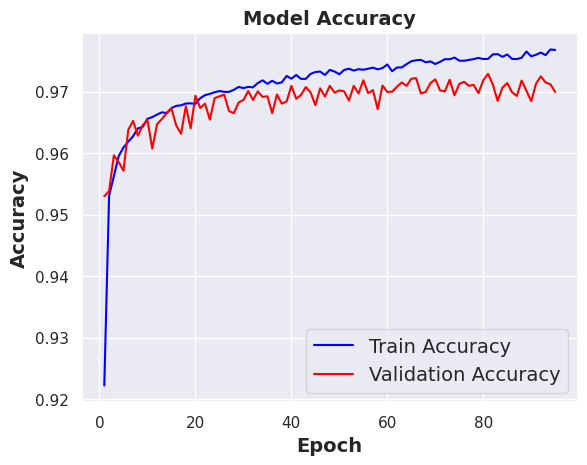

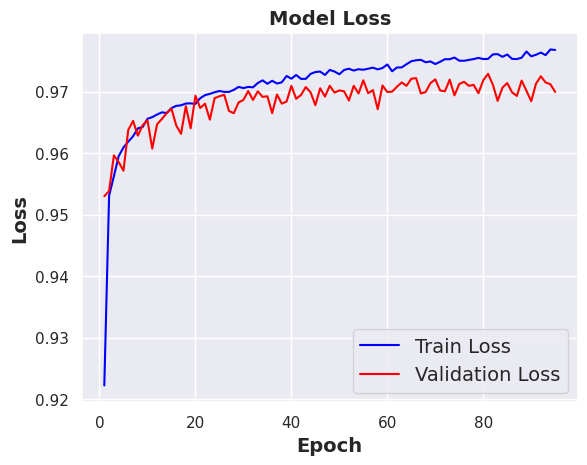

In [7]:
# Initialize the PyTorch model
n_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
in_channels = X_train.shape[1]
model = InceptionModel(in_channels, n_classes).to(device)

train_loss_arr = []
train_accuracy_arr = []
val_loss_arr = []
val_accuracy_arr = []

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
best_model_state = None  # Initialize a variable to store the best model state
counter = 0

# Training loop
epochs = 100
epoch1 =0
print('\n')
for epoch in range(epochs):
    epoch1+=1
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total_train += batch_y.size(0)
        correct_train += predicted.eq(batch_y).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss_arr.append(train_loss)
    train_accuracy_arr.append(train_accuracy)
    
    model.eval()
    
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x)
            val_loss += criterion(output, batch_y).item()
            _, predicted = output.max(1)
            total_val += batch_y.size(0)
            correct_val += predicted.eq(batch_y).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_loss_arr.append(val_loss)
    val_accuracy_arr.append(val_accuracy)
    
    model.train()
        
    #Check for early stopping and save best model state
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()  # Store the current best model state
        torch.save(best_model_state, "image_classifiers/EX2_SG_CNN_Model.pth")
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        if best_model_state is not None:
            model.load_state_dict(best_model_state)  # Restore best model state
        counter = 0  # Reset the counter    
        break

    print(f'Epoch [{epoch+1}/{epochs}] - '
      f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
      f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Create the range of epochs
epoch_range = range(1, epoch1+1)

# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_accuracy_arr, label='Train Accuracy', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_accuracy_arr, label='Validation Accuracy', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Accuracy', fontsize=14, weight='bold')
plt.title('Model Accuracy', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.show()
plt.savefig("image_classifiers/EX1_SG_CNN_Accuracy.png")
# Show the plot
plt.close()

# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_accuracy_arr, label='Train Loss', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_accuracy_arr, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Loss', fontsize=14, weight='bold')
plt.title('Model Loss', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.show()
plt.savefig("image_classifiers/EX1_SG_CNN_Loss.png")
# Show the plot
plt.close()


#### 4. Testing the Model



Identified 19440 correct labels out of 20000 labels
Accuracy: 0.972
Precision: 0.9720883387612143
Recall: 0.9720418840125437
F1 Score: 0.971999747997732
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9750  198]
 [ 362 9690]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      9948
           1       0.98      0.96      0.97     10052

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

(array([    0,     1,     2, ..., 19997, 19998, 19999]), 0.972, 0.9720883387612143, 0.9720418840125437, array([[9750,  198],
       [ 362, 9690]]), '              precision    recall  f1-score   support\n\n           0       0.96      0.98      0.97      9948\n           1       0.98      0.96      0.97     10052\n\n    accuracy                           0.97     20000\n   macro avg       0.97      0.97      0.97  

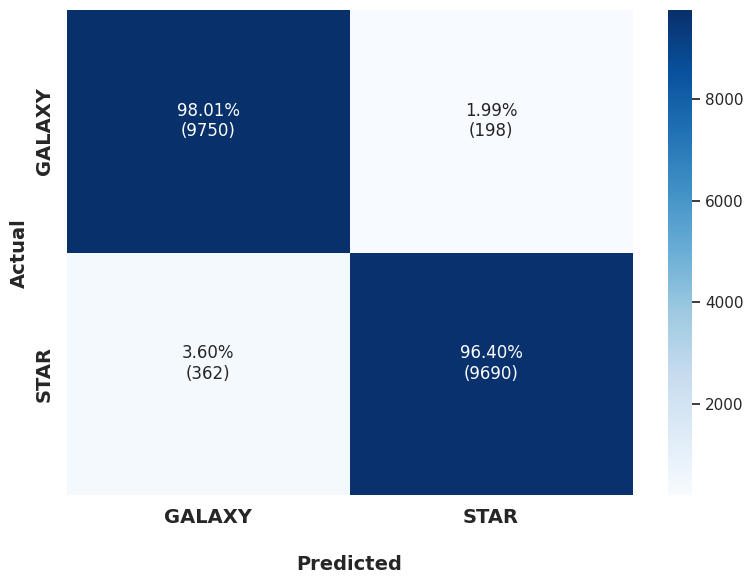

In [8]:
torch.cuda.empty_cache()

# Set the model to evaluation mode
# Set the model to evaluation mode
model.eval()
y_test_pred = torch.empty(0).to(device)
print('\n')
# Generate predictions
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)

        y_test_pred = torch.cat((y_test_pred, pred), dim=0)

y_test_pred = y_test_pred.cpu().numpy()
y_test_pred = y_test_pred.argmax(axis=1)
print(get_metrics(y_test_pred, y_test, label_strings))

# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cf_matrix_percentage = metrics.confusion_matrix(y_test, y_test_pred, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.show()
plt.savefig("image_classifiers/EX2_SG_CNN_CM.png")
plt.close()

